In [ ]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

In [ ]:
load_dotenv()
model= ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [32]:
class SentimentSchema(BaseModel):
    sentiment: Literal['Positive','Negative'] = Field(description="Sentiment of the user Review")

In [33]:
class DiagonsisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')


In [34]:
Structured_model = model.with_structured_output(SentimentSchema)
Structured_model2 = model.with_structured_output(DiagonsisSchema)

In [35]:
# prompt = f'what is the sentiment of the folloing review - The product is worst'

# Structured_model.invoke(prompt).sentiment

In [36]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal['Positive','Negative'] 
    diagonsis:dict
    response:str

In [37]:
def find_sentiment(state:ReviewState):
    prompt = f' For the following review find out the sentiment \n {state['review']}'

    sentiment = Structured_model.invoke(prompt)
    return{'sentiment':sentiment}


def check_sentiments(state:ReviewState)-> Literal["positive_response","run_diagonsis"]:
    if state['sentiment']=="Positive":
        return "positive_response"
    else:
        return "run_diagonsis"


In [38]:
def positive_response(state:ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""

    response = model.invoke(prompt).content
    return{'response':response}


def run_diagonsis(state:ReviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    
    response = Structured_model2.invoke(prompt)

    return {'diagonsis':response.model_dump()}



def negative_response(state:ReviewState):
    
    diagonsis = state['diagonsis']
    
    prompt = f"""You are a support assistant.
The user had a '{diagonsis['issue_type']}' issue, sounded '{diagonsis['tone']}', and marked urgency as '{diagonsis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content
    return{'respnse':'response'}

In [39]:
graph = StateGraph(ReviewState)

# Add Node
graph.add_node("find_sentiment",find_sentiment)
graph.add_node("run_diagonsis",run_diagonsis)
graph.add_node("positive_response",positive_response)
graph.add_node("negative_response",negative_response)


# Add Edges

graph.add_edge(START,"find_sentiment")

graph.add_conditional_edges("find_sentiment",check_sentiments)

graph.add_edge("positive_response",END)
graph.add_edge("run_diagonsis","negative_response")
graph.add_edge("negative_response",END)


workflow= graph.compile()

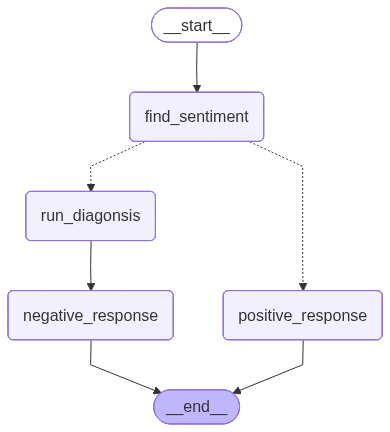

In [40]:
workflow

In [44]:
intial_state={
    'review': "best app used so far best app. "
}
workflow.invoke(intial_state)

{'review': 'best app used so far best app. ',
 'sentiment': SentimentSchema(sentiment='Positive'),
 'diagonsis': {'issue_type': 'Other', 'tone': 'calm', 'urgency': 'low'}}